In [1]:
import pandas as pd
import sqlite3

In [2]:
import sqlite3

# 连接到数据库
conn = sqlite3.connect('../getTradeData/binance-15.db')

# 创建游标对象
cursor = conn.cursor()


# 执行查询语句，获取所有表名
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

tables = [table[0] for table in tables]

# 关闭游标和连接
cursor.close()
conn.close()


In [3]:
def feature(df):
    # Calculate RSI
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Calculate EMA
    ema_short = df['close'].ewm(span=12).mean()
    ema_long = df['close'].ewm(span=26).mean()

    # Calculate MACD
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=9).mean()
    histogram = macd - signal_line

    # Add RSI, EMA, and MACD to the DataFrame
    df['rsi'] = rsi
    df['ema_short'] = ema_short
    df['ema_long'] = ema_long
    df['macd'] = macd
    df['signal_line'] = signal_line
    df['histogram'] = histogram

    df['sma_3'] = df['close'].rolling(window=3).mean()
    df['sma_6'] = df['close'].rolling(window=6).mean()
    df['sma_12'] = df['close'].rolling(window=12).mean()
    # 波动率
    df['volatility_std'] = df['close'].rolling(window=5).std()
    df['pct_change'] = df['close'].pct_change()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['std_20'] = df['close'].rolling(window=20).std()
    df['bollinger_upper'] = df['sma_20'] + 2 * df['std_20']
    df['bollinger_middle'] = df['sma_20']
    df['bollinger_lower'] = df['sma_20'] - 2 * df['std_20']
    df['diff_bollinger_upper'] = df['close'] - df['bollinger_upper']
    df['diff_bollinger_lower'] = df['close'] - df['bollinger_lower']
    df['diff_sma_3'] = df['close'] - df['sma_3']
    df['diff_sma_6'] = df['close'] - df['sma_6']
    df['diff_sma_12'] = df['close'] - df['sma_12']
    return df

In [4]:
def find_extrema_indices_no_slip(close, window_size):
    max_indices = []
    min_indices = []

    for i in range(0, len(close) - window_size + 1, window_size):
        window = close[i:i+window_size]
        max_value = max(window)
        min_value = min(window)
        max_index = window.index(max_value) + i
        min_index = window.index(min_value) + i
        if max_index != i and max_index != i + window_size - 1 and max_index not in max_indices:
            max_indices.append(max_index)
        if min_index != i and min_index != i + window_size - 1 and min_index not in min_indices:
            min_indices.append(min_index)
    
    return max_indices, min_indices

In [5]:
def find_extrema_indices(close, window_size):
    max_indices = []
    min_indices = []

    for i in range(0, len(close) - window_size + 1):
        window = close[i:i+window_size]
        max_value = max(window)
        min_value = min(window)
        max_index = window.index(max_value) + i
        min_index = window.index(min_value) + i
        if max_index != i and max_index != i + window_size - 1 and max_index not in max_indices:
            max_indices.append(max_index)
        if min_index != i and min_index != i + window_size - 1 and min_index not in min_indices:
            min_indices.append(min_index)
    
    return min_indices,max_indices 

In [6]:
def pair_max_min(max_indices, min_indices):
    paired_max_indices = []
    paired_min_indices = []

    # Merge and sort indices
    all_indices = sorted(max_indices + min_indices)

    for i in range(len(all_indices) - 1):
        if all_indices[i] in max_indices and all_indices[i+1] in min_indices:
            paired_max_indices.append(all_indices[i])
            paired_min_indices.append(all_indices[i+1])

    return paired_max_indices, paired_min_indices


In [10]:
def signal(df,close,buy_indices,sell_indices,buy_indices_slip,sell_indices_slip):
    buy_sell_signal = [1]*len(close)
    for buy in buy_indices_slip:
        buy_sell_signal[buy] = 2
    for buy1 in sell_indices_slip:
        buy_sell_signal[buy1] = 3
    for buy2 in buy_indices:
        buy_sell_signal[buy2] = 4
    for buy3 in sell_indices:
        buy_sell_signal[buy3] = 6    
    df[['signal']] = pd.DataFrame(data=buy_sell_signal)
    return df

In [11]:
df_list = []
count = 1
numeric_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']

for table in tables:
    connection = sqlite3.connect("../getTradeData/binance-15.db")
    sql_query = f"SELECT * FROM {table}"
    df = pd.read_sql_query(sql_query, connection)
    connection.close()
    df[numeric_columns] = df[numeric_columns].astype(float)
    df = feature(df)
    df = df.iloc[20:]
    df.reset_index(drop=True, inplace=True)
    close = df[['close']]
    close  = close.values.tolist()
    close = [item for sublist in close for item in sublist]
    min_indices,max_indices = find_extrema_indices_no_slip(close,300)
    min_indices_slip,max_indices_slip = find_extrema_indices(close,300)
    buy_indices,sell_indices = pair_max_min(max_indices, min_indices)
    df = signal(df,close,buy_indices,sell_indices,min_indices_slip,max_indices_slip)
    print(f"{table}-{count}")
    df[['tag']] = pd.DataFrame(data=[count] * len(close))
    count += 1
    df_list.append(df)


ETHUSDT-1
BTCUSDT-2
LTCUSDT-3
BCHUSDT-4
EOSUSDT-5
XRPUSDT-6
ETCUSDT-7
ADAUSDT-8
ZECUSDT-9
BNBUSDT-10
LINKUSDT-11
USDCUSDT-12
MATICUSDT-13
FILUSDT-14
AXSUSDT-15
DODOUSDT-16
INJUSDT-17
CFXUSDT-18
ENSUSDT-19
LINAUSDT-20
DOGEUSDT-21
UNIUSDT-22
XLMUSDT-23
TRXUSDT-24
XMRUSDT-25
XTZUSDT-26
ATOMUSDT-27
VETUSDT-28
NEOUSDT-29
QTUMUSDT-30
SUSHIUSDT-31
OPUSDT-32
ICPUSDT-33
AVAXUSDT-34
DOTUSDT-35
SOLUSDT-36
AAVEUSDT-37


In [12]:
merged_df = pd.concat(df_list, axis=0)

In [13]:
merged_df.shape

(4888431, 35)

In [14]:
df.shape

(91907, 35)

In [15]:
merged_df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore', 'rsi', 'ema_short',
       'ema_long', 'macd', 'signal_line', 'histogram', 'sma_3', 'sma_6',
       'sma_12', 'volatility_std', 'pct_change', 'sma_20', 'std_20',
       'bollinger_upper', 'bollinger_middle', 'bollinger_lower',
       'diff_bollinger_upper', 'diff_bollinger_lower', 'diff_sma_3',
       'diff_sma_6', 'diff_sma_12', 'signal', 'tag'],
      dtype='object')

In [16]:
merged_df.to_csv("all-coin.csv",encoding="utf-8-sig")

In [17]:
df_filtered = merged_df[merged_df['tag'] = 3]

SyntaxError: invalid syntax (Temp/ipykernel_1472/2117535039.py, line 1)

In [23]:
df = merged_df[merged_df['tag'] == 10][['close','signal']]

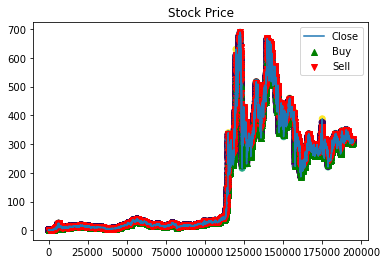

In [25]:
import matplotlib.pyplot as plt
# 绘制折线图
plt.plot(df.index, df['close'], label='Close')
plt.scatter(df.index, df['close'], c=df['signal'], cmap='viridis')

# 添加买入、卖出标记
buy_indices = df.index[df['signal'] == 2]
sell_indices = df.index[df['signal'] == 3]
plt.scatter(buy_indices, df.loc[buy_indices, 'close'], color='green', marker='^', label='Buy')
plt.scatter(sell_indices, df.loc[sell_indices, 'close'], color='red', marker='v', label='Sell')

# 设置图例和标题
plt.legend()
plt.title('Stock Price')

# 显示图形
plt.show()

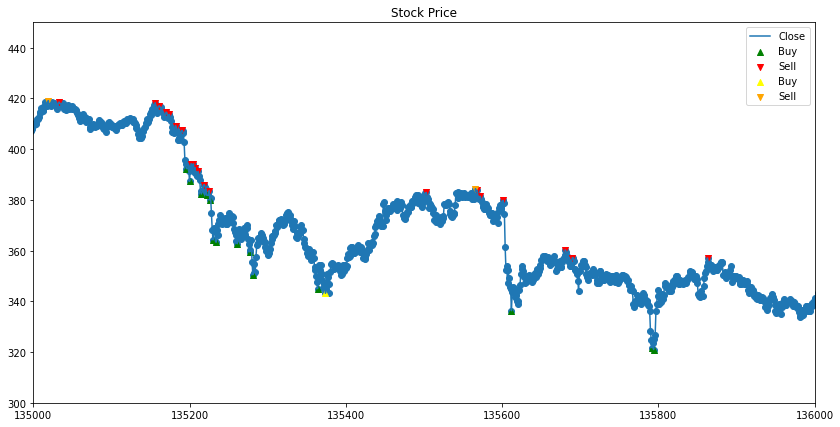

In [36]:
plt.figure(figsize=(14,7))
# 绘制折线图
plt.plot(df.index, df['close'], label='Close')
plt.scatter(df.index, df['close'])

# 添加买入、卖出标记
buy_indices = df.index[df['signal'] == 2]
sell_indices = df.index[df['signal'] == 3]
plt.scatter(buy_indices, df.loc[buy_indices, 'close'], color='green', marker='^', label='Buy')
plt.scatter(sell_indices, df.loc[sell_indices, 'close'], color='red', marker='v', label='Sell')
buy_indices = df.index[df['signal'] == 4]
sell_indices = df.index[df['signal'] == 6]
plt.scatter(buy_indices, df.loc[buy_indices, 'close'], color='yellow', marker='^', label='Buy')
plt.scatter(sell_indices, df.loc[sell_indices, 'close'], color='orange', marker='v', label='Sell')
# 设置图例和标题
plt.legend()
plt.title('Stock Price')

# 限制X轴和Y轴的显示范围
plt.xlim(135000, 136000)  # 设置X轴的显示范围
plt.ylim(300, 450)  # 设置Y轴的显示范围

# 显示图形
plt.show()